---
title: "Instrumental variable analysis and Mendelian randomization"
mathjax: true
toc: true
toc_sticky: true
categories: [data science, statistics]
---

Instrumental variable analysis is one method for causal inference. This approach relies on deconfounding an explanatory variable $X$ by using an exogenous variable ($Z$, the instrument) for the outcome $Y$. Here I wanted to have a better understanding of instrumental variable analysis as a path to applying it to Mendelian randomization, especially when my outcome is a disease, a binary outcome.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit
from utils import draw_causal_graph, standardize

In [2]:
RANDOM_SEED = 73   # McElreath's random seed
# RANDOM_SEED = 8927   # pymc repo random seed
np.random.seed(RANDOM_SEED)
sns.set_context("talk")
sns.set_palette("colorblind")

NOTES:
- wages-education, MVN vs. stats 2SLS
- wages-education, MVN with binary outcome, show with 2SLS?
- provide a mendelian randomization example

# McElreath's wages and education example

## Model 14.6

Re-do the Statistical Rethinking example model 14.6 first. Here I reference [pymc translation](https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_14.ipynb) of R code 14.26.

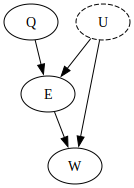

In [3]:
draw_causal_graph(
    edge_list=[("Q", "E"), ("U", "E"), ("U", "W"), ("E", "W")],
    node_props={"U": {"style": "dashed"}},
    graph_direction="TD",
)

$$ \left( \begin{array}{c} W_i \\ {E_i} \end{array} \right) \sim \text{MVNormal} \left( \begin{array}{c}{\mu_{W_i}}  \\ {\mu_{E_i} } \end{array} , \textbf{S} \right)    $$

$$ \mu_{W_i} = \alpha_W + \beta_{EW} W_i  $$
$$ \mu_{E_i} = \alpha_E + \beta_{QE} E_i  $$
$$ \alpha_W, \alpha_E \sim \text{Normal}(0, 0.2) $$
$$ \beta_{EW}, \beta_{QE} \sim \text{Normal}(0, 1.5) $$

$$
\textbf{S} = \begin{pmatrix} \sigma_{W}^2 & \rho\sigma_{W}\sigma_{E} \\ 
                \rho\sigma_{W}\sigma_{E} & \sigma_{E}^2 \end{pmatrix} = \begin{pmatrix} \sigma_{P} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{W} & 0 \\ 0 & \sigma_{E} \end{pmatrix}
$$

$$
\textbf{R} \sim \text{LKJCorr}(2)
$$

In [4]:
N = 500
U_sim = np.random.normal(size=N)
Q_sim = np.random.randint(1, 5, N)
E_sim = np.random.normal(loc=U_sim + Q_sim, size=N)
W_sim = np.random.normal(loc=U_sim + 0 * E_sim, size=N)
dat_sim = pd.DataFrame.from_dict(
    {"W": standardize(W_sim), "E": standardize(E_sim), "Q": standardize(Q_sim)}
)
dat_sim.head()

,W,E,Q
0,1.147366,1.442103,0.428599
1,1.153508,0.386141,-1.372236
2,0.948497,0.413627,-0.471819
3,-0.137755,0.193661,-0.471819
4,-1.653446,-2.076577,-0.471819


In [5]:
with pm.Model() as m14_6:
    aW = pm.Normal("aW", 0.0, 0.2)
    aE = pm.Normal("aE", 0.0, 0.2)
    bEW = pm.Normal("bEW", 0.0, 0.5)
    bQE = pm.Normal("bQE", 0.0, 0.5)

    muW = aW + bEW * dat_sim.E.values
    muE = aE + bQE * dat_sim.Q.values
    chol, _, _ = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    WE_obs = pm.Data("WE_obs", dat_sim[["W", "E"]].values, mutable=True)
    WE = pm.MvNormal("WE", mu=pt.stack([muW, muE]).T, chol=chol, observed=WE_obs)

    trace_14_6 = pm.sample(1000, random_seed=RANDOM_SEED)
    trace_14_6.rename({"chol_cov_corr": "Rho", "chol_cov_stds": "Sigma"}, inplace=True)

az.summary(trace_14_6, var_names=["aW", "aE", "bEW", "bQE", "Rho", "Sigma"], round_to=2)

/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/pymc/data.py:416: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Output()

/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.
/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
aW,-0.00,0.04,-0.08,0.08,0.0,0.0,4150.99,3688.87,1.0
aE,-0.00,0.03,-0.06,0.06,0.0,0.0,3692.50,2853.40,1.0
bEW,0.05,0.06,-0.08,0.16,0.0,0.0,2131.69,2631.97,1.0
bQE,0.68,0.03,0.62,0.74,0.0,0.0,2963.05,3214.42,1.0
"Rho[0, 0]",1.00,0.00,1.00,1.00,0.0,0.0,4000.00,4000.00,NaN
"Rho[0, 1]",0.46,0.05,0.36,0.56,0.0,0.0,2179.65,2729.02,1.0
"Rho[1, 0]",0.46,0.05,0.36,0.56,0.0,0.0,2179.65,2729.02,1.0
"Rho[1, 1]",1.00,0.00,1.00,1.00,0.0,0.0,3641.00,3807.84,1.0
Sigma[0],0.99,0.04,0.92,1.06,0.0,0.0,2727.13,2943.37,1.0
Sigma[1],0.73,0.02,0.69,0.78,0.0,0.0,4500.07,3156.00,1.0


Above values approximate McElreath's R code examples.

In [6]:
df_trace_14_6_summary = az.summary(trace_14_6, var_names=["aW", "aE", "bEW", "bQE", "Rho", "Sigma"], round_to=2)
df_trace_14_6_summary.head()

/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
aW,-0.00,0.04,-0.08,0.08,0.0,0.0,4150.99,3688.87,1.0
aE,-0.00,0.03,-0.06,0.06,0.0,0.0,3692.50,2853.40,1.0
bEW,0.05,0.06,-0.08,0.16,0.0,0.0,2131.69,2631.97,1.0
bQE,0.68,0.03,0.62,0.74,0.0,0.0,2963.05,3214.42,1.0
"Rho[0, 0]",1.00,0.00,1.00,1.00,0.0,0.0,4000.00,4000.00,NaN


In [13]:
dat_sim.head()

,W,E,Q,R,R_size
0,1.147366,1.442103,0.428599,1,2
1,1.153508,0.386141,-1.372236,2,2
2,0.948497,0.413627,-0.471819,2,2
3,-0.137755,0.193661,-0.471819,1,2
4,-1.653446,-2.076577,-0.471819,1,2


In [15]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS

# First stage: Regress education on Q
first_stage = sm.OLS(dat_sim["E"], sm.add_constant(dat_sim["Q"])).fit()

# Predicted education
dat_sim["E_hat"] = first_stage.predict(sm.add_constant(dat_sim["Q"]))

# Second stage: Regress wages on predicted education (instrumented)
second_stage = sm.OLS(
    dat_sim["W"], sm.add_constant(dat_sim["E_hat"])
).fit()

# Summary of the second stage regression
second_stage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5562
Date:                Sun, 09 Jun 2024   Prob (F-statistic):              0.456
Time:                        12:12:22   Log-Likelihood:                -709.19
No. Observations:                 500   AIC:                             1422.
Df Residuals:                     498   BIC:                             1431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.776e-17      0.045    6.2e-16      1.000      -0.088       0.088
E_hat          0.0489      0.066      0.746      0.456      -0.080       0.178
==============================================================================
Omnibus:                        0.243   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.885   Jarque-Bera (JB):                0.357
Skew:                           0.014   Prob(JB):                        0.836
Kurtosis:                       2.872   Cond. No.                         1.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
first_stage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      E   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     434.7
Date:                Sun, 09 Jun 2024   Prob (F-statistic):           7.20e-70
Time:                        12:13:37   Log-Likelihood:                -552.59
No. Observations:                 500   AIC:                             1109.
Df Residuals:                     498   BIC:                             1118.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.665e-16      0.033  -5.09e-15      1.000      -0.064       0.064
Q              0.6827      0.033     20.850      0.000       0.618       0.747
==============================================================================
Omnibus:                        0.118   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.943   Jarque-Bera (JB):                0.036
Skew:                          -0.007   Prob(JB):                        0.982
Kurtosis:                       3.039   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Can you recover the proper coefficients if the outcome is binary?

Create a new variable R (rich or not) that is the result of increased wages.

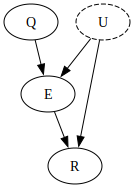

In [7]:
draw_causal_graph(
    edge_list=[("Q", "E"), ("U", "E"), ("U", "R"), ("E", "R")],
    node_props={"U": {"style": "dashed"}},
    graph_direction="TD",
)

$$ R_i \sim \text{Binomial}(n, p_i) $$
$$ \text{logit}(p_i) = W_i $$
$$ \left( \begin{array}{c} W_i \\ {E_i} \end{array} \right) \sim \text{MVNormal} \left( \begin{array}{c}{\mu_{W_i}}  \\ {\mu_{E_i} } \end{array} , \textbf{S} \right)    $$

$$ \mu_{W_i} = \alpha_W + \beta_{EW} W_i  $$
$$ \mu_{E_i} = \alpha_E + \beta_{QE} E_i  $$
$$ \alpha_W, \alpha_E \sim \text{Normal}(0, 0.2) $$
$$ \beta_{EW}, \beta_{QE} \sim \text{Normal}(0, 1.5) $$

$$
\textbf{S} = \begin{pmatrix} \sigma_{W}^2 & \rho\sigma_{W}\sigma_{E} \\ 
                \rho\sigma_{W}\sigma_{E} & \sigma_{E}^2 \end{pmatrix} = \begin{pmatrix} \sigma_{P} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{W} & 0 \\ 0 & \sigma_{E} \end{pmatrix}
$$

$$
\textbf{R} \sim \text{LKJCorr}(2)
$$

In [8]:
index_val = dat_sim.index.values
R_size = 2
dat_sim['R'] = stats.binom.rvs(n=R_size, p=expit(W_sim))  # not standardized
dat_sim['R_size'] = R_size
dat_sim.head()

,W,E,Q,R,R_size
0,1.147366,1.442103,0.428599,1,2
1,1.153508,0.386141,-1.372236,2,2
2,0.948497,0.413627,-0.471819,2,2
3,-0.137755,0.193661,-0.471819,1,2
4,-1.653446,-2.076577,-0.471819,1,2


When I was looking at the [pymc documentation for `MvNormal`](https://www.pymc.io/projects/docs/en/stable/_modules/pymc/distributions/multivariate.html#MvNormal), I noticed that there was a note: "For unobserved values it can be better to use a non-centered parametrization". They provided an example implementation which I use below. This is tricky because $E$ and $R$ are observed but we are pretending $W$ is not observed in this case. I wil use this non-centered parameterization.

In testing, using the non-centered paramaterization, along with increasing `target_accept` gave me better `r_hat` values.

In [63]:
with pm.Model() as m14_6_logit:
    aW = pm.Normal("aW", 0.0, 0.2)
    aE = pm.Normal("aE", 0.0, 0.2)
    bEW = pm.Normal("bEW", 0.0, 0.5)
    bQE = pm.Normal("bQE", 0.0, 0.5)

    muW = aW + bEW * dat_sim.E.values
    muE = aE + bQE * dat_sim.Q.values
    
    # non-centered paramterization following pymc docs example
    sd_dist = pm.Exponential.dist(1.0, shape=2)
    chol, _, _ = pm.LKJCholeskyCov('chol_cov', n=2, eta=2,
        sd_dist=sd_dist, compute_corr=True)
    WE_raw = pm.Normal('WE_raw', mu=0, sigma=1, shape=(len(index_val), 2))
    WE = pm.Deterministic('WE', pt.dot(chol, WE_raw.T).T)

    # link function
    # p = pm.math.invlogit(WE[index_val, 0])   # gets the W
    # r = pm.Binomial("r", n=dat_sim['R_size'], p=p, observed=dat_sim["R"])

    # Logit model for R
    logit_p = pm.Deterministic('logit_p', WE[index_val, 0])
    R_obs = pm.Binomial('R_obs', n=dat_sim['R_size'], logit_p=logit_p, observed=dat_sim['R'])

    trace_14_6_logit = pm.sample(1000, random_seed=RANDOM_SEED, target_accept=0.95)
    trace_14_6_logit.rename({"chol_cov_corr": "Rho", "chol_cov_stds": "Sigma"}, inplace=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov, WE_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 132 seconds.


In [64]:
df_trace_14_6_logit = az.summary(trace_14_6_logit)
df_trace_14_6_logit

/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"WE[0, 0]",0.016,0.939,-1.730,1.797,0.013,0.017,5377.0,2439.0,1.0
"WE[0, 1]",0.003,1.328,-2.371,2.772,0.021,0.018,5075.0,2877.0,1.0
"WE[1, 0]",-0.002,0.954,-1.829,1.758,0.012,0.018,6017.0,2104.0,1.0
"WE[1, 1]",-0.011,1.292,-2.354,2.601,0.020,0.018,5073.0,3185.0,1.0
"WE[2, 0]",0.931,0.980,-0.845,2.885,0.015,0.014,4573.0,2494.0,1.0
...,...,...,...,...,...,...,...,...,...
logit_p[495],0.010,0.954,-1.805,1.775,0.012,0.018,6612.0,2760.0,1.0
logit_p[496],0.915,1.018,-0.976,2.793,0.015,0.015,4757.0,2599.0,1.0
logit_p[497],-0.013,0.933,-1.808,1.732,0.012,0.016,6110.0,2813.0,1.0
logit_p[498],-0.909,0.949,-2.802,0.704,0.012,0.013,6034.0,3069.0,1.0


Text(0.5, 1.0, 'm14.6 with logistic link')

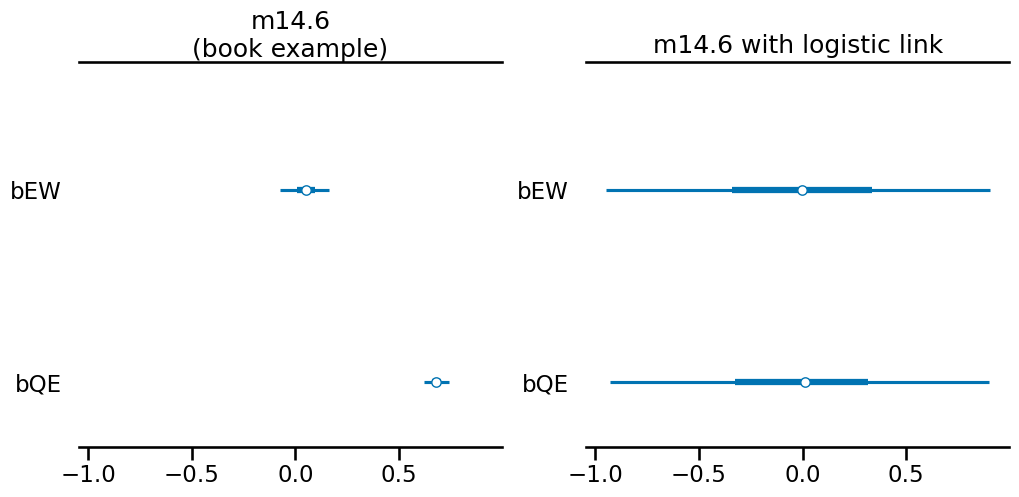

In [65]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5), sharex=True)
az.plot_forest(trace_14_6, var_names=['bEW', 'bQE'], combined=True, ax=ax0)
az.plot_forest(trace_14_6_logit, var_names=['bEW', 'bQE'], combined=True, ax=ax1)
ax0.set_title("m14.6\n(book example)")
ax1.set_title("m14.6 with logistic link")

### Visualize relationship of $W_i$ and R

In [25]:
# Get the W_i values which were assigned to vals[j, 0] in non-centered parameterization
df_trace_14_6_logit[df_trace_14_6_logit.index.str.contains('WE\[')].head()

<>:2: SyntaxWarning: invalid escape sequence '\['
<>:2: SyntaxWarning: invalid escape sequence '\['
/var/folders/xy/ddmp8rj12qbcmtfqxt7rhc6c0000gn/T/ipykernel_42093/933250025.py:2: SyntaxWarning: invalid escape sequence '\['
  df_trace_14_6_logit[df_trace_14_6_logit.index.str.contains('WE\[')].head()


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"WE[0, 0]",0.639,1.408,-1.290,3.540,0.091,0.064,347.0,448.0,1.03
"WE[0, 1]",-0.014,1.418,-2.371,2.979,0.025,0.018,3792.0,2650.0,1.00
"WE[1, 0]",0.620,1.376,-1.402,3.415,0.089,0.063,343.0,457.0,1.03
"WE[1, 1]",-0.000,1.412,-2.777,2.713,0.023,0.020,4305.0,2901.0,1.00
"WE[2, 0]",0.661,1.443,-1.255,3.839,0.090,0.064,417.0,342.0,1.03


In [26]:
df_trace_14_6_logit_W = df_trace_14_6_logit[df_trace_14_6_logit.index.str.contains('WE\[') & df_trace_14_6_logit.index.str.contains('0]')]
df_trace_14_6_logit_W.head()

<>:1: SyntaxWarning: invalid escape sequence '\['
<>:1: SyntaxWarning: invalid escape sequence '\['
/var/folders/xy/ddmp8rj12qbcmtfqxt7rhc6c0000gn/T/ipykernel_42093/4015736962.py:1: SyntaxWarning: invalid escape sequence '\['
  df_trace_14_6_logit_W = df_trace_14_6_logit[df_trace_14_6_logit.index.str.contains('WE\[') & df_trace_14_6_logit.index.str.contains('0]')]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"WE[0, 0]",0.639,1.408,-1.290,3.540,0.091,0.064,347.0,448.0,1.03
"WE[1, 0]",0.620,1.376,-1.402,3.415,0.089,0.063,343.0,457.0,1.03
"WE[2, 0]",0.661,1.443,-1.255,3.839,0.090,0.064,417.0,342.0,1.03
"WE[3, 0]",-0.646,1.464,-3.566,1.607,0.116,0.082,318.0,434.0,1.03
"WE[4, 0]",-0.640,1.410,-3.470,1.546,0.091,0.064,384.0,369.0,1.03


Text(0.5, 0, 'R\n(binary label)')

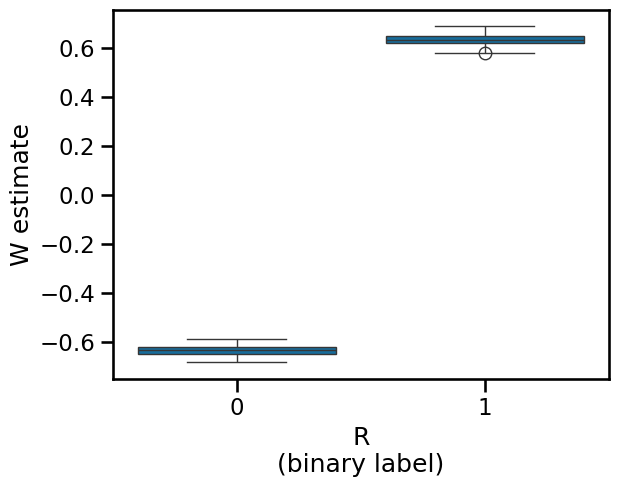

In [28]:
# merge and plot relationship of W_i with 
f, ax = plt.subplots()
sns.boxplot(data=df_trace_14_6_logit_W.reset_index().merge(dat_sim, left_index=True, right_index=True), x='R', y='mean', ax=ax)
ax.set_ylabel("W estimate")
ax.set_xlabel("R\n(binary label)")

I get the relationship I expect between $W$ and $R$.

## Logit in model, non-centered

In [110]:
dat_sim.head()

,W,E,Q,R,R_size
0,1.147366,1.442103,0.428599,1,2
1,1.153508,0.386141,-1.372236,2,2
2,0.948497,0.413627,-0.471819,2,2
3,-0.137755,0.193661,-0.471819,1,2
4,-1.653446,-2.076577,-0.471819,0,2


In [112]:
dat_sim.describe()

,W,E,Q,R,R_size
count,5.000000e+02,5.000000e+02,5.000000e+02,500.00000,500.0
mean,1.776357e-17,-1.669775e-16,3.552714e-18,1.01600,2.0
std,1.001002e+00,1.001002e+00,1.001002e+00,0.80314,0.0
min,-2.604903e+00,-2.793234e+00,-1.372236e+00,0.00000,2.0
25%,-6.709705e-01,-7.085318e-01,-4.718186e-01,0.00000,2.0
50%,-3.676654e-03,-3.972081e-02,4.285986e-01,1.00000,2.0
75%,6.921176e-01,7.813519e-01,1.329016e+00,2.00000,2.0
max,3.112482e+00,2.338276e+00,1.329016e+00,2.00000,2.0


In [114]:
with pm.Model() as m14_6_logit2:
    aW = pm.Normal("aW", 0.0, 0.2)
    aE = pm.Normal("aE", 0.0, 0.2)
    bEW = pm.Normal("bEW", 0.0, 0.5)
    bQE = pm.Normal("bQE", 0.0, 0.5)

    muW = aW + bEW * dat_sim.E.values
    muE = aE + bQE * dat_sim.Q.values

    # non-centered
    sd_dist = pm.Exponential.dist(1.0, shape=2)
    chol, _, _ = pm.LKJCholeskyCov('chol_cov', n=2, eta=2,
        sd_dist=sd_dist, compute_corr=True)
    WE_raw = pm.Normal('WE_raw', mu=0, sigma=0.5, shape=(len(index_val), 2))
    WE = pm.Deterministic('WE', pt.dot(chol, WE_raw.T).T)

    logit_p = pm.Deterministic('logit_p', WE[index_val, 0])
    RE_obs = pm.Data("RE_obs", dat_sim[["R", "E"]].values, mutable=True)    
    YY = pm.MvNormal("YY", mu=pt.stack([logit_p, muE]).T, chol=chol, observed=RE_obs)

    R = pm.Binomial('R', n=dat_sim['R_size'], logit_p=logit_p, observed=dat_sim['R'])

    trace_14_6_logit2 = pm.sample(1000, random_seed=RANDOM_SEED, target_accept=0.95)
    trace_14_6_logit2.rename({"chol_cov_corr": "Rho", "chol_cov_stds": "Sigma"}, inplace=True)


TypeError: Shared variable values can not be symbolic.

Text(0.5, 1.0, 'm14.6 with logistic link')

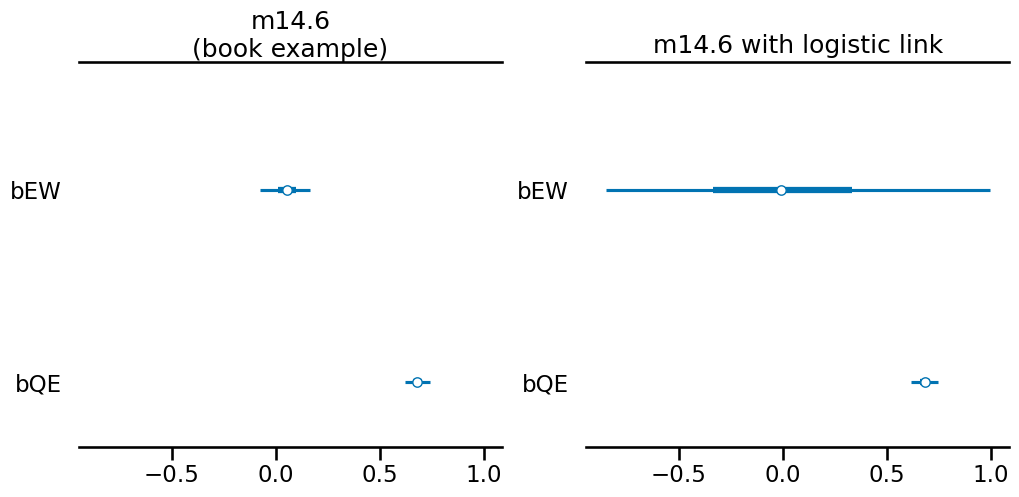

In [68]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5), sharex=True)
az.plot_forest(trace_14_6, var_names=['bEW', 'bQE'], combined=True, ax=ax0)
az.plot_forest(trace_14_6_logit2, var_names=['bEW', 'bQE'], combined=True, ax=ax1)
ax0.set_title("m14.6\n(book example)")
ax1.set_title("m14.6 with logistic link")

In [69]:
az.summary(trace_14_6, var_names=['bEW', 'bQE'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bEW,0.051,0.064,-0.075,0.165,0.001,0.001,2132.0,2632.0,1.0
bQE,0.680,0.032,0.621,0.742,0.001,0.000,2963.0,3214.0,1.0


In [70]:
az.summary(trace_14_6_logit2, var_names=['bEW', 'bQE'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bEW,-0.002,0.494,-0.852,0.994,0.005,0.01,10950.0,2937.0,1.00
bQE,0.682,0.033,0.616,0.743,0.000,0.00,10105.0,2713.0,1.01


## Logit in model, centered

In [48]:
dat_sim.head()

,W,E,Q,R,R_size
0,1.147366,1.442103,0.428599,1,2
1,1.153508,0.386141,-1.372236,1,2
2,0.948497,0.413627,-0.471819,2,2
3,-0.137755,0.193661,-0.471819,1,2
4,-1.653446,-2.076577,-0.471819,1,2


In [106]:
with pm.Model() as m14_6_logit3:
    aW = pm.Normal("aW", 0.0, 0.2)
    aE = pm.Normal("aE", 0.0, 0.2)
    bEW = pm.Normal("bEW", 0.0, 0.5)
    bQE = pm.Normal("bQE", 0.0, 0.5)

    muW = aW + bEW * dat_sim.E.values
    muE = aE + bQE * dat_sim.Q.values

    # centered
    sd_dist = pm.Exponential.dist(1.0, shape=2)
    chol, _, _ = pm.LKJCholeskyCov('chol_cov', n=2, eta=2,
        sd_dist=sd_dist, compute_corr=True)

    #WE_obs = pm.Data("WE_obs", dat_sim[["W", "E"]].values, mutable=True)
    # WE = pm.MvNormal("WE", mu=pt.stack([muW, muE]).T, chol=chol, observed=WE_obs)
    # MU = pm.MvNormal("WE", mu=pt.stack([muW, muE]).T, chol=chol)

# --------    
    # WE_raw = pm.Normal('WE_raw', mu=0, sigma=1, shape=(len(index_val), 2))
    # WE = pm.Deterministic('WE', pt.dot(chol, WE_raw.T).T)

    RE_obs = pm.Data("RE_obs", dat_sim[["R", "E"]].values, mutable=True)    
    YY = pm.MvNormal("YY", mu=pt.stack([muE, muE]).T, chol=chol, observed=RE_obs)
    logit_p = pm.Data('logit_p', YY[index_val, 0])
    #logit_p = pm.Deterministic('logit_p', YY[index_val, 0])

    R_obs = pm.Binomial('R_obs', n=dat_sim['R_size'], logit_p=logit_p, observed=dat_sim['R'])

    trace_14_6_logit3 = pm.sample(1000, random_seed=RANDOM_SEED, target_accept=0.95)
    trace_14_6_logit3.rename({"chol_cov_corr": "Rho", "chol_cov_stds": "Sigma"}, inplace=True)


/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/pymc/data.py:416: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov, WE]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 462 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Text(0.5, 1.0, 'm14.6 with logistic link')

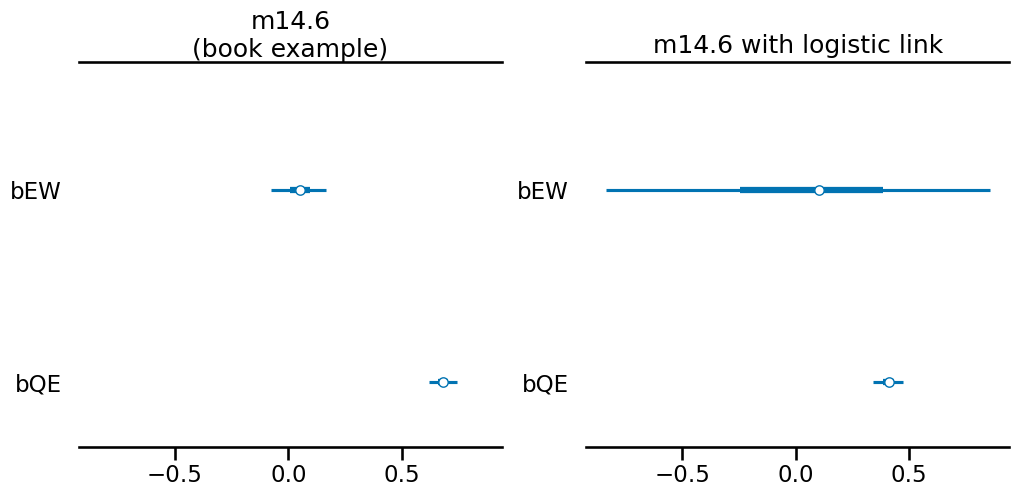

In [107]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5), sharex=True)
az.plot_forest(trace_14_6, var_names=['bEW', 'bQE'], combined=True, ax=ax0)
az.plot_forest(trace_14_6_logit3, var_names=['bEW', 'bQE'], combined=True, ax=ax1)
ax0.set_title("m14.6\n(book example)")
ax1.set_title("m14.6 with logistic link")

In [108]:
az.summary(trace_14_6, var_names=['bEW', 'bQE'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bEW,0.051,0.064,-0.075,0.165,0.001,0.001,2132.0,2632.0,1.0
bQE,0.680,0.032,0.621,0.742,0.001,0.000,2963.0,3214.0,1.0


In [109]:
az.summary(trace_14_6_logit2, var_names=['bEW', 'bQE'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bEW,-0.002,0.494,-0.852,0.994,0.005,0.01,10950.0,2937.0,1.00
bQE,0.682,0.033,0.616,0.743,0.000,0.00,10105.0,2713.0,1.01


## Logit4, re-do McElreath's code

In [9]:
with pm.Model() as m14_6_logit4:
    aW = pm.Normal("aW", 0.0, 0.2)
    aE = pm.Normal("aE", 0.0, 0.2)
    bEW = pm.Normal("bEW", 0.0, 0.5)
    bQE = pm.Normal("bQE", 0.0, 0.5)

    muW = pm.Deterministic("muW", aW + bEW * dat_sim.E.values)
    muE = pm.Deterministic("muE", aE + bQE * dat_sim.Q.values)

    chol, _, _ = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    # for ( j in 1:500 ) MU[j] = [ muW[j] , muE[j] ]';
    MU = pt.stack([muW, muE]).T

    # for ( j in 1:500 ) YY[j] = [ logit_p[j] , E[j] ]';
    # logit_p = pm.logit(muW)
    # logit_p = pm.Data('logit_p', YY[index_val, 0])

    # YY_obs = pm.Deterministic("YY_obs", pt.stack([logit_p, dat_sim["E"].values]))  # TypeError: Variables that depend on other nodes cannot be used for observed data.
    YY_obs = pm.Data("YY_obs", dat_sim[["R", "E"]].values) # SamplingError: Initial evaluation of model at starting point failed!

    # YY ~ multi_normal( MU , quad_form_diag(Rho , Sigma) );
    YY = pm.MvNormal("YY", mu=MU, chol=chol, observed=YY_obs)

    # R ~ binomial_logit(Rsize,logit_p);
    logit_p = pm.Deterministic('logit_p', YY[index_val, 0])
    R = pm.Binomial('R', n=R_size, logit_p=logit_p, observed=dat_sim['R'])
    
    trace_14_6_logit4 = pm.sample(1000, random_seed=RANDOM_SEED, target_accept=0.95)
    trace_14_6_logit4.rename({"chol_cov_corr": "Rho", "chol_cov_stds": "Sigma"}, inplace=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aW, aE, bEW, bQE, chol_cov]


Output()

/Users/benlacar/opt/anaconda3/envs/pymc_env_2405/lib/python3.12/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 140 seconds.


Text(0.5, 1.0, 'm14.6 with logistic link')

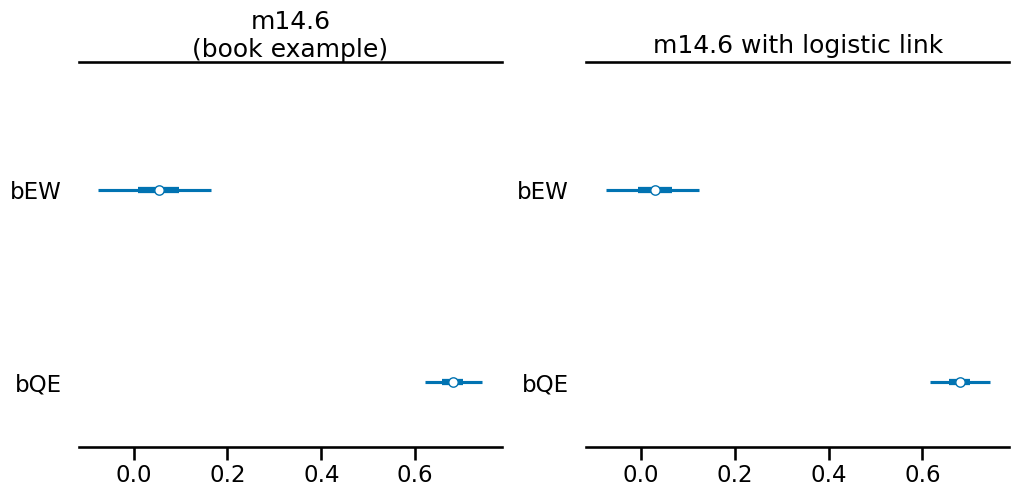

In [10]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5), sharex=True)
az.plot_forest(trace_14_6, var_names=['bEW', 'bQE'], combined=True, ax=ax0)
az.plot_forest(trace_14_6_logit4, var_names=['bEW', 'bQE'], combined=True, ax=ax1)
ax0.set_title("m14.6\n(book example)")
ax1.set_title("m14.6 with logistic link")

In [11]:
az.summary(trace_14_6, var_names=['bEW', 'bQE'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bEW,0.051,0.064,-0.075,0.165,0.001,0.001,2132.0,2632.0,1.0
bQE,0.680,0.032,0.621,0.742,0.001,0.000,2963.0,3214.0,1.0


In [12]:
az.summary(trace_14_6_logit4, var_names=['bEW', 'bQE'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bEW,0.029,0.053,-0.073,0.124,0.001,0.001,2353.0,2754.0,1.0
bQE,0.680,0.034,0.615,0.744,0.001,0.000,3346.0,2807.0,1.0


# --- Everything below this can be ignored --- 

# My Mendelian randomization example

In [ ]:
# Set random seed for reproducibility
np.random.seed(19)

# coefficients
bUP = -1
bUD = 1
bGP = 1
bPD = 1

# Simulate data
n = 500
U_sim = np.random.normal(size=n)  # exogenous, unobserved confound
G_sim = np.random.choice(
    [0, 1, 2], size=n, p=[0.25, 0.5, 0.25]
)  # exogenous, genotype as denoted by number of alleles
P_sim = np.random.normal(
    loc = bUP * U_sim + bGP * G_sim
)  # generated by U and G, assume more alleles is positively associated with protein level
D_sim = np.random.normal(loc= bUD*U_sim + bUP*P_sim)  # generated by U and P levels

# Standardize or transform
G_standardized = standardize(G_sim.reshape(-1, 1)).flatten()
P_standardized = standardize(P_sim.reshape(-1, 1)).flatten()
D_binary = stats.bernoulli.rvs(
    expit(D_sim)
)  # transformed to 0/1 to represent disease state


df_data_sim = pd.DataFrame(
    {
        "G": G_standardized,
        "P": P_standardized,
        "D": D_binary,
    }
)

df_data_sim.head()

## Model 0, ignore confound, just look at impact of P

$$ D_i \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \mu_{P_i} $$
$$ \mu_{P_i} = \alpha + \beta_P P_i $$
$$ \alpha, \beta_P \sim \text{Normal}(0, 1.5) $$

In [ ]:
with pm.Model() as m0:

    # priors
    a = pm.Normal("a", 0, 1.5)
    bP = pm.Normal("bP", 0, 1.5)

    # link function
    p = pm.math.invlogit(a + bP * df_data_sim["P"])

    d = pm.Bernoulli("d", p=p, observed=df_data_sim["D"])

    trace_m0 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=False
    )

In [ ]:
az.summary(trace_m0)

Our estimate is closer to 2 than it is to 1.

## Model 1, add G as a predictor

$$ D_i \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \mu_{PG_i} $$
$$ \mu_{PG_i} = \alpha + \beta_P P_i + \beta_G G_i $$
$$ \alpha, \beta_P, \beta_G \sim \text{Normal}(0, 1.5) $$

In [ ]:
with pm.Model() as m1:

    # priors
    a = pm.Normal("a", 0, 1.5)
    bP = pm.Normal("bP", 0, 1.5)
    bG = pm.Normal("bG", 0, 1.5)

    # link function
    p = pm.math.invlogit(a + bP * df_data_sim["P"] + bG * df_data_sim["G"])

    d = pm.Bernoulli("d", p=p, observed=df_data_sim["D"])

    trace_m1 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=False
    )

In [ ]:
az.summary(trace_m1)

The estimate is even worse. This is an example of bias amplification.

## Model 2, MR

Model the joint error structure through mu.


$$ D_i \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = {D_{\text{cont,i}}} $$
$$ \left( \begin{array}{c} D_{\text{cont,i}} \\ {P_i} \end{array} \right) \sim \text{MVNormal} \left( \begin{array}{c}{\mu_{D_\text{cont,i}}}  \\ {\mu_{P_i} } \end{array} , \textbf{S} \right)    $$

$$ \mu_{D_\text{cont,i}} = \alpha_D + \beta_P P_i  $$
$$ \mu_{P_i} = \alpha_P + \beta_G G_i  $$
$$ \alpha_D, \alpha_P \sim \text{Normal}(0, 1.5) $$
$$ \beta_P, \beta_G \sim \text{Normal}(0, 1.5) $$

$$
\textbf{S} = \begin{pmatrix} \sigma_{P}^2 & \rho\sigma_{P}\sigma_{G} \\ 
                \rho\sigma_{P}\sigma_{G} & \sigma_{G}^2 \end{pmatrix} = \begin{pmatrix} \sigma_{P} & 0 \\ 0 & \sigma_{\beta} \end{pmatrix} \textbf{R} \begin{pmatrix} \sigma_{P} & 0 \\ 0 & \sigma_{G} \end{pmatrix}
$$

$$
\textbf{R} \sim \text{LKJCorr}(2)
$$

In [ ]:
df_data_sim.head()

In [ ]:
df_data_sim['G'].value_counts()

In [ ]:
subj_index = df_data_sim.index.values

In [ ]:
df_data_sim.head()

In [ ]:
with pm.Model() as m2:
    chol, Rho_, sigma = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    aD = pm.Normal("aD", mu=0, sigma=1.5)
    aP = pm.Normal("aP", mu=0, sigma=1.5)
    bPD = pm.Normal("bPD", mu=0, sigma=1.5)
    bGP = pm.Normal("bGP", mu=0, sigma=1.5)

    muD = aD + bPD * df_data_sim["P"]
    muP = aP + bGP * df_data_sim["G"]

    dp = pm.MvNormal("dp", mu=pt.stack([muD, muP]).T, chol=chol)

    # link function
    p = pm.math.invlogit(dp[subj_index, 0])

    d = pm.Bernoulli("d", p=p, observed=df_data_sim["D"])

    trace_m2 = pm.sample(1000, target_accept=0.9)

In [ ]:
az.summary(trace_m2, var_names=["bGP", "bPD", "chol_cov", "chol_cov_corr"])

# Check with statsmodels

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n = 1000

# Simulate genotype SNP (0, 1, 2) assuming Hardy-Weinberg equilibrium

genotype = np.random.choice([0, 1, 2], size=n, p=[0.25, 0.5, 0.25])
# Simulate protein intensity affected by genotype
# Assume beta_genotype is the effect size of genotype on protein intensity
beta_genotype = 0.5
protein_intensity = beta_genotype * genotype + np.random.normal(size=n)

# Simulate disease outcome affected by protein intensity
# Assume beta_protein is the effect size of protein intensity on disease
beta_protein = 1.0
disease = beta_protein * protein_intensity + np.random.normal(size=n)

# Create a DataFrame
data = pd.DataFrame(
    {"genotype": genotype, "protein_intensity": protein_intensity, "disease": disease}
)

data.head()

In [ ]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS

# First stage: Regress protein intensity on genotype
first_stage = sm.OLS(data["protein_intensity"], sm.add_constant(data["genotype"])).fit()

# Predicted protein intensity
data["protein_intensity_hat"] = first_stage.predict(sm.add_constant(data["genotype"]))

# Second stage: Regress disease on predicted protein intensity (instrumented)
second_stage = sm.OLS(
    data["disease"], sm.add_constant(data["protein_intensity_hat"])
).fit()

# Summary of the second stage regression
second_stage.summary()

# Check that coefficient using binomial GLM can be recovered from simulated data

In [ ]:
n = 200
a = np.random.normal(size=n)           # intercept at 0
bD = np.random.normal(loc=1, scale=0.2, size=n)   # bD coefficient at 1, make the spread narrow
X = np.random.normal(size=n)           # predictor variable
mu = a + bD*X
D_logit = stats.bernoulli.rvs(p=expit(mu))
df_data_sim_logit = pd.DataFrame(
    {'X':X,
     'mu':mu,
     'D':D_logit}
)

In [ ]:
df_data_sim_logit.head()

In [ ]:
sns.scatterplot(
    data=df_data_sim_logit,
    x='X',
    y='mu',
    hue='D'
)

$$ D_i \sim \text{Bernoulli}(p_i) $$
$$ \text{logit}(p_i) = \mu_i $$
$$ \mu_i = \alpha + \beta X_i $$
$$ \alpha \sim \text{Normal}(0,1.5) $$
$$ \beta \sim \text{Normal}(0,1.5) $$

In [ ]:
with pm.Model() as m_logit:

    # priors
    a = pm.Normal("a", mu=0, sigma=2)
    b = pm.Normal("b", mu=0, sigma=2)

    mu = a + b*df_data_sim_logit['X']

    # link function
    p = pm.math.invlogit(mu)

    d = pm.Bernoulli("d", p=p, observed=df_data_sim_logit["D"])

    trace_m_logit = pm.sample(1000, target_accept=0.9)

In [ ]:
az.summary(trace_m_logit)

In [45]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jun 06 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

seaborn   : 0.13.2
scipy     : 1.13.0
numpy     : 1.26.4
pytensor  : 2.20.0
arviz     : 0.18.0
pandas    : 2.2.2
matplotlib: 3.8.4
pymc      : 5.15.0

Watermark: 2.4.3

